In [1]:

import pandas as pd
import numpy as np
import copy 
from collections import defaultdict

## Ex.1 (4pts) Reading in distance matrices

Write a function that is able to read distance matrices and store them, for instance, in a dictionary of dictionaries so that distances can b e accessed like dist['D']['B'].


In [2]:
#### Dict method ####

In [3]:
def read_distance_dict(filename):
    with open(r'C:\Users\Ram Kumar R S\Downloads\SoSe 2020\\'+filename,'r') as f:
        dist={}
        content=f.readlines()
        dkey=' '.join(content[0])
        dk=dkey.split()
        for line in content[1:]:
            entries=line.split()
            label=entries[0]
            distance=entries[1:]
            dist[label]={}
            for k,v in zip(dk,distance):
                if label!=k:
                    dist[label][k]=float(v)
    return dist       
matrix=(read_distance_dict('small-distances.txt'))
matrix['A']['B']

4.0

In [4]:
#### Dataframe method ####

In [5]:
def read_distance_df(filename):
    
    distance = open(r'C:\Users\Ram Kumar R S\Downloads\SoSe 2020\\'+filename,'r').read().splitlines()
    distance_seq = ''.join(distance[0].split())
    distance = distance[1:] # cut header
    distance = [line[2:] for line in distance]
    distance = [line.split() for line in distance]

    distance = [list(map(int, line)) for line in distance[:]]
    distance = pd.DataFrame(distance)
    for i in range(len(distance_seq)):
        distance.rename(columns={ distance.columns[i]: distance_seq[i] }, inplace = True)

    rows_dict = defaultdict()
    
    for i in range(len(distance_seq)):
        rows_dict[i] = distance_seq[i]
    distance.rename(index=rows_dict, inplace = True)
        
    return distance


small_distances = read_distance_df("small-distances.txt")
print("Small Distances\n",small_distances,"\n")
print("Dictionary Query [A][B] =",small_distances["A"]["B"])

Small Distances
    A  B  C  D  E
A  0  4  1  2  5
B  4  0  5  2  3
C  1  5  0  3  6
D  2  2  3  0  3
E  5  3  6  3  0 

Dictionary Query [A][B] = 4


## Ex.2 (4pts) Number of elements of a nested tuple

First, write a function that counts the number of elementary objects in a nested tuple. I.e., the function should return 3 for (('A','B'),'C') and 5 for ((('A','B'),'C'),('D','E')). This function will b e helpful when determining cluster distances.


In [6]:
def count_tuples(object):
    """function to count the number of elements in a tuple by flattening it
    arg: input tuple
    return : count"""
    def flatten2list(object):
        gather = []
        for item in object:
            if isinstance(item, (list, tuple, set)):
                gather.extend(flatten2list(item))            
            else:
                gather.append(item)
        return gather
    return len(flatten2list(object))
print(count_tuples((('A','B'),'C')))
print(count_tuples(((('A','B'),'C'),('D','E'))))

3
5


# Ex.3 (4pts) Merging clusters

Write a function taking three parameters: a distance matrix (i.e. a dictionary of dictionaries as in exercise 1) and two clusters (represented as strings / tuples) that merges two clusters by up dating the distance matrix.


In [7]:
### dict form distance matrix ####

In [8]:
def merge_cluster(dist,a,b):
    m,n=count_tuples(a),count_tuples(b)
    c=(a,b)
    dist[c]={}
    for k in dist.keys():
        if k==a or k==b or k==c:
            continue
        nd=(dist[k][a]*n + dist[k][b]*m)/(m+n)
        dist[c][k]=nd
        dist[k][c]=nd
    del dist[a]
    del dist[b]
    
    for k in dist.keys():
        if k!=c:
            del dist[k][a]
            del dist[k][b]
    return c


merge_cluster(matrix,'D','E')

('D', 'E')

In [9]:
### Dataframe based distance matrix ###

In [10]:
def cluster_merging(dist_matrix, clusterA, clusterB):
    # Agglomerative Clustering

    # Init
    dist_matrix_reduced = copy.copy(dist_matrix) # Copying for not changing the object outside and easier debugging
    cardinality_clusterA = count_tuples(clusterA)
    cardinality_clusterB = count_tuples(clusterB)

    # Calculate Score + Rename + Delete + Transpose + Rename + Delete + Transpose. Should work as long as its symmetric. I guess matrix transpose shouldn't be too expensive (maybe only indices are getting changed)
    reduced_column = (cardinality_clusterA * dist_matrix_reduced[clusterA] + cardinality_clusterB * dist_matrix_reduced[clusterB]) / ( cardinality_clusterA + cardinality_clusterB )
    dist_matrix_reduced[(clusterA, clusterB)] = reduced_column
    del(dist_matrix_reduced[clusterA])
    del(dist_matrix_reduced[clusterB])
    dist_matrix_reduced = dist_matrix_reduced.T

    reduced_column = (cardinality_clusterA * dist_matrix_reduced[clusterA] + cardinality_clusterB * dist_matrix_reduced[clusterB]) / ( cardinality_clusterA + cardinality_clusterB )
    dist_matrix_reduced[(clusterA, clusterB)] = reduced_column
    del(dist_matrix_reduced[clusterA])
    del(dist_matrix_reduced[clusterB])
    dist_matrix_reduced = dist_matrix_reduced.T

    # Identity 0-ing
    dist_matrix_reduced[(clusterA,clusterB)][(clusterA,clusterB)] = 0

    return dist_matrix_reduced


# Call with Distance Matrix and Keys / Tuples to be removed
cluster_iter_1 = cluster_merging(small_distances, ('C'), ('B'))

print(cluster_iter_1)

          A    D    E  (C, B)
A       0.0  2.0  5.0     2.5
D       2.0  0.0  3.0     2.5
E       5.0  3.0  0.0     4.5
(C, B)  2.5  2.5  4.5     0.0


# Ex.4 (4pts) Find closest clusters

In [11]:
### dict based distance matrix ###

In [12]:
def finding_small_distance_main(matrix):
    def finding_small_distance(matrix):
        list_key_val=[]
        for i in matrix.values():
            min_val=min(i.values()) # minimum value of  each row -- value (in dict of dict)
            min_key=''.join([k for k, v in i.items() if v == min(i.values())][0])  # key of that min value
            key= ''.join([str(k) for k, v in matrix.items() if v ==i])  # main key of that value
            #print(min_val,min_key,key)
            min_val_min_key_key=((min_val,min_key,key))
            list_key_val.append(min_val_min_key_key)
        return tuple([k for k in sorted(list_key_val,key=lambda item: item[0],reverse=False)][0])
    
    return tuple(finding_small_distance(matrix)[1:]),finding_small_distance(matrix)[0]

    
#cluster1,cluster2,value=
cluster,val=finding_small_distance_main(matrix)
cluster,val

(('C', 'A'), 1.0)

In [13]:
### data frame based distance matrix ###

In [14]:
def find_smallest_distance(dist_matrix):
    min_val = dist_matrix.replace(0, np.nan).stack().min()
    min_idx = dist_matrix.replace(0, np.nan).stack().idxmin()
    return min_idx, min_val


nearest_clusters = find_smallest_distance(small_distances)
print("The neirest clusters are", nearest_clusters[0],"with a distance of", nearest_clusters[1])

The neirest clusters are ('A', 'C') with a distance of 1.0


# Ex.5 (4pts) Hierarchical clustering

In [15]:
def hierarchical_clustering(_distance_matrix):
    distance_matrix = copy.copy(_distance_matrix) 
    heights = dict.fromkeys(distance_matrix,0)
    while len(distance_matrix) > 1:
        cluster, value = find_smallest_distance(distance_matrix)
        distance_matrix = cluster_merging(distance_matrix, cluster[0], cluster[1])
        heights.update({cluster : value/2})
    return distance_matrix, heights
tree_smalldistances, cluster_heights_smalldistances = hierarchical_clustering(small_distances)
print("Tree Clusters by agglomoration - small-distances.txt:\n", *tree_smalldistances)


Tree Clusters by agglomoration - small-distances.txt:
 (('A', 'C'), ('E', ('B', 'D')))


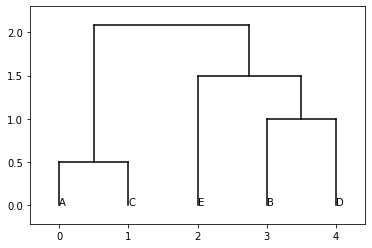

None


In [18]:
from showtree import showtree
print(showtree(*tree_smalldistances, cluster_heights_smalldistances))
